# Use Soft Actor-Critic with Auto $\alpha$ Tuning to Play LunarLander-v2

TensorFlow version

In [1]:
%matplotlib inline

import sys
import logging
import itertools

import numpy as np
np.random.seed(0)
import scipy.special
import pandas as pd
import gym
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
tf.random.set_seed(0)
from tensorflow import nn
from tensorflow import losses
from tensorflow import optimizers
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

logging.basicConfig(level=logging.INFO,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('LunarLander-v2', new_step_api=True)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

08:02:30 [INFO] env: <LunarLander<LunarLander-v2>>
08:02:30 [INFO] action_space: Discrete(4)
08:02:30 [INFO] observation_space: Box(-inf, inf, (8,), float32)
08:02:30 [INFO] reward_range: (-inf, inf)
08:02:30 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 50}
08:02:30 [INFO] _max_episode_steps: 1000
08:02:30 [INFO] _elapsed_steps: None
08:02:30 [INFO] id: LunarLander-v2
08:02:30 [INFO] entry_point: gym.envs.box2d:LunarLander
08:02:30 [INFO] reward_threshold: 200
08:02:30 [INFO] nondeterministic: False
08:02:30 [INFO] max_episode_steps: 1000
08:02:30 [INFO] _kwargs: {}
08:02:30 [INFO] _env_name: LunarLander


In [3]:
class DQNReplayer:
    def __init__(self, capacity):
        self.memory = pd.DataFrame(index=range(capacity),
                columns=['state', 'action', 'reward', 'next_state', 'termination'])
        self.i = 0
        self.count = 0
        self.capacity = capacity

    def store(self, *args):
        self.memory.loc[self.i] = np.asarray(args, dtype=object)
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample(self, size):
        indices = np.random.choice(self.count, size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [4]:
class SACAgent:
    def __init__(self, env):
        state_dim = env.observation_space.shape[0]
        self.action_n = env.action_space.n
        self.gamma = 0.99

        self.replayer = DQNReplayer(100000)

        # create alpha
        self.target_entropy = np.log(self.action_n) / 4.
        self.ln_alpha_tensor = tf.Variable(0., dtype=tf.float32)
        self.alpha_optimizer = optimizers.Adam(0.0003)

        # create actor
        self.actor_net = self.build_net(hidden_sizes=[256, 256],
                output_size=self.action_n, output_activation=nn.softmax)

        # create Q critic
        self.q0_net = self.build_net(hidden_sizes=[256, 256],
                output_size=self.action_n)
        self.q1_net = self.build_net(hidden_sizes=[256, 256],
                output_size=self.action_n)

        # create V critic
        self.v_evaluate_net = self.build_net(input_size=state_dim,
                hidden_sizes=[256, 256])
        self.v_target_net = models.clone_model(self.v_evaluate_net)

    def build_net(self, hidden_sizes, output_size=1,
                activation=nn.relu, output_activation=None, input_size=None,
                loss=losses.mse, learning_rate=0.0003):
        model = keras.Sequential()
        for layer_idx, hidden_size in enumerate(hidden_sizes):
            kwargs = {'input_shape': (input_size,)} if \
                    layer_idx == 0 and input_size is not None else {}
            model.add(layers.Dense(units=hidden_size,
                    activation=activation, **kwargs))
        model.add(layers.Dense(units=output_size,
                activation=output_activation))
        optimizer = optimizers.Adam(learning_rate)
        model.compile(optimizer=optimizer, loss=loss)
        return model

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, termination):
        probs = self.actor_net.predict(observation[np.newaxis], verbose=0)[0]
        action = np.random.choice(self.action_n, p=probs)
        if self.mode == 'train':
            self.trajectory += [observation, reward, termination, action]
            if len(self.trajectory) >= 8:
                state, _, _, action, next_state, reward, termination, _ = \
                        self.trajectory[-8:]
                self.replayer.store(state, action, reward, next_state, termination)
            if self.replayer.count >= 500:
                self.learn()
        return action

    def close(self):
        pass

    def update_net(self, target_net, evaluate_net, learning_rate=0.005):
        average_weights = [(1. - learning_rate) * t + learning_rate * e for t, e
                in zip(target_net.get_weights(), evaluate_net.get_weights())]
        target_net.set_weights(average_weights)

    def learn(self):
        states, actions, rewards, next_states, terminations = \
                self.replayer.sample(128)

        # update alpha
        all_probs = self.actor_net.predict(states, verbose=0)
        probs = np.take_along_axis(all_probs, actions[np.newaxis, :], axis=-1)
        ln_probs = np.log(probs.clip(1e-6, 1.))
        mean_ln_prob = ln_probs.mean()
        with tf.GradientTape() as tape:
            alpha_loss_tensor = -self.ln_alpha_tensor * (mean_ln_prob +
                    self.target_entropy)
        grads = tape.gradient(alpha_loss_tensor, [self.ln_alpha_tensor,])
        self.alpha_optimizer.apply_gradients(zip(grads, [self.ln_alpha_tensor,]))

        # update V critic
        q0s = self.q0_net.predict(states, verbose=0)
        q1s = self.q1_net.predict(states, verbose=0)
        q01s = np.minimum(q0s, q1s)
        pis = self.actor_net.predict(states, verbose=0)
        alpha = tf.exp(self.ln_alpha_tensor).numpy()
        entropic_q01s = pis * q01s - alpha * scipy.special.xlogy(pis, pis)
        v_targets = entropic_q01s.sum(axis=-1)
        self.v_evaluate_net.fit(states, v_targets, verbose=0)
        self.update_net(self.v_target_net, self.v_evaluate_net)

        # update Q critic
        next_vs = self.v_target_net.predict(next_states, verbose=0)
        q_targets = rewards[:, np.newaxis] + \
                self.gamma * (1. - terminations[:, np.newaxis]) * next_vs
        np.put_along_axis(q0s, actions.reshape(-1, 1), q_targets, -1)
        np.put_along_axis(q1s, actions.reshape(-1, 1), q_targets, -1)
        self.q0_net.fit(states, q0s, verbose=0)
        self.q1_net.fit(states, q1s, verbose=0)

        # update actor
        state_tensor = tf.convert_to_tensor(states, dtype=tf.float32)
        q0s_tensor = self.q0_net(state_tensor)
        with tf.GradientTape() as tape:
            probs_tensor = self.actor_net(state_tensor)
            alpha_tensor = tf.exp(self.ln_alpha_tensor)
            losses_tensor = alpha_tensor * tf.math.xlogy(probs_tensor,
                    probs_tensor) - probs_tensor * q0s_tensor
            actor_loss_tensor = tf.reduce_sum(losses_tensor, axis=-1)
        grads = tape.gradient(actor_loss_tensor,
                self.actor_net.trainable_variables)
        self.actor_net.optimizer.apply_gradients(zip(grads,
                self.actor_net.trainable_variables))


agent = SACAgent(env)

08:02:31 [INFO] ==== train ====
08:02:37 [INFO] train episode 0: reward = -75.95, steps = 112
08:02:44 [INFO] train episode 1: reward = -236.09, steps = 133
08:02:48 [INFO] train episode 2: reward = -112.13, steps = 76
08:02:52 [INFO] train episode 3: reward = -117.56, steps = 83
08:02:56 [INFO] train episode 4: reward = -197.16, steps = 79
08:03:51 [INFO] train episode 5: reward = -152.45, steps = 130
08:04:31 [INFO] train episode 6: reward = -506.29, steps = 87
08:05:27 [INFO] train episode 7: reward = -259.64, steps = 122
08:06:09 [INFO] train episode 8: reward = -412.11, steps = 90
08:06:43 [INFO] train episode 9: reward = -101.70, steps = 70
08:07:16 [INFO] train episode 10: reward = -102.76, steps = 67
08:08:00 [INFO] train episode 11: reward = -137.17, steps = 94
08:08:43 [INFO] train episode 12: reward = -114.29, steps = 94
08:09:21 [INFO] train episode 13: reward = -283.18, steps = 83
08:09:53 [INFO] train episode 14: reward = -137.77, steps = 68
08:10:27 [INFO] train episode 

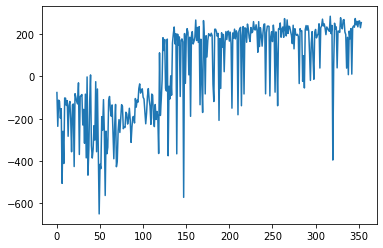

In [5]:
def play_episode(env, agent, seed=None, mode=None, render=False):
    observation = env.reset(seed=seed)
    reward, termination, truncation = 0., False, False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, termination)
        if render:
            env.render()
        if termination or truncation:
            break
        observation, reward, termination, truncation, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env, agent, seed=episode,
            mode='train')
    episode_rewards.append(episode_reward)
    logging.info('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > 250:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.info('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [6]:
env.close()